<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-s/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 4 Exercise 3

Questions to answer in the report

 1.   Run the program with different dimX values. For each one, approximate the FLOPS (floating-point operation per second) achieved in computing the SMPV (sparse matrix multiplication). Report FLOPS at different input sizes in a FLOPS.
  2.  Run the program with dimX=1024 and vary nsteps from 100 to 10000. Plot the relative error of the approximation at different nstep. What do you observe?
   3.  Compare the performance with and without the prefetching in Unified Memory. How is the performance impact? [Optional: using nvprof to get metrics on UM]


In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Nov 24 12:11:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  7


## First exercise of the second assignment


In [ ]:
%%writefile hw4_ex3.cu
#include <cublas_v2.h>
#include <cuda_runtime_api.h>
#include <cusparse_v2.h>
#include <math.h>
#include <numeric>
#include <stdlib.h>
#include <sys/time.h>
#include <thrust/device_ptr.h>
#include <thrust/sequence.h>

#define gpuCheck(stmt)                                       \
    do {                                                     \
        cudaError_t err = stmt;                              \
        if (err != cudaSuccess) {                            \
            printf("ERROR. Failed to run stmt %s\n", #stmt); \
            break;                                           \
        }                                                    \
    } while (0)

// Macro to check the cuBLAS status
#define cublasCheck(stmt)                                           \
    do {                                                            \
        cublasStatus_t err = stmt;                                  \
        if (err != CUBLAS_STATUS_SUCCESS) {                         \
            printf("ERROR. Failed to run cuBLAS stmt %s\n", #stmt); \
            break;                                                  \
        }                                                           \
    } while (0)

// Macro to check the cuSPARSE status
#define cusparseCheck(stmt)                                           \
    do {                                                              \
        cusparseStatus_t err = stmt;                                  \
        if (err != CUSPARSE_STATUS_SUCCESS) {                         \
            printf("ERROR. Failed to run cuSPARSE stmt %s\n", #stmt); \
            break;                                                    \
        }                                                             \
    } while (0)

struct timeval t_start, t_end;
void cputimer_start() { gettimeofday(&t_start, 0); }
double cputimer_stop(const char *info) {
    gettimeofday(&t_end, 0);
    double time = (1000000.0 * (t_end.tv_sec - t_start.tv_sec) + t_end.tv_usec -
                   t_start.tv_usec);
    printf("Timing - %s. \t\tElasped %.0f microseconds \n", info, time);
    return time;
}

// Initialize the sparse matrix needed for the heat time step
void matrixInit(double *A, int *ArowPtr, int *AcolIndx, int dimX,
                double alpha) {
    // Stencil from the finete difference discretization of the equation
    double stencil[] = {1, -2, 1};
    // Variable holding the position to insert a new element
    size_t ptr = 0;
    // Insert a row of zeros at the beginning of the matrix
    ArowPtr[1] = ptr;
    // Fill the non zero entries of the matrix
    for (int i = 1; i < (dimX - 1); ++i) {
        // Insert the elements: A[i][i-1], A[i][i], A[i][i+1]
        for (int k = 0; k < 3; ++k) {
            // Set the value for A[i][i+k-1]
            A[ptr] = stencil[k];
            // Set the column index for A[i][i+k-1]
            AcolIndx[ptr++] = i + k - 1;
        }
        // Set the number of newly added elements
        ArowPtr[i + 1] = ptr;
    }
    // Insert a row of zeros at the end of the matrix
    ArowPtr[dimX] = ptr;
}

float calculateFLOPS(int nvz, int dimX, float time_ms) {
    // nvz: Number of non-zero elements in the sparse matrix
    // dimX: Dimension of the output vector
    // time_ms: Kernel execution time in milliseconds
    float ops = 3.0f * nnz * dimX;  // Each 1*A*temp + 0*tmp operation counts as 3 FLOPS, 1 multiply/add and 2 multiply
    return ops / (time_ms / 1000.0f);  // Convert ms to seconds
}

int main(int argc, char **argv) {
    int device = 0;           // Device to be used
    int dimX;                 // Dimension of the metal rod
    int nsteps;               // Number of time steps to perform
    double alpha = 0.4;       // Diffusion coefficient
    double *temp;             // Array to store the final time step
    double *A;                // Sparse matrix A values in the CSR format
    int *ARowPtr;             // Sparse matrix A row pointers in the CSR format
    int *AColIndx;            // Sparse matrix A col values in the CSR format
    int nzv;                  // Number of non zero values in the sparse matrix
    double *tmp;              // Temporal array of dimX for computations
    size_t bufferSize = 0;    // Buffer size needed by some routines
    void *buffer = nullptr;   // Buffer used by some routines in the libraries
    int concurrentAccessQ;    // Check if concurrent access flag is set
    double zero = 0;          // Zero constant
    double one = 1;           // One constant
    double norm;              // Variable for norm values
    double error;             // Variable for storing the relative error
    double tempLeft = 200.;   // Left heat source applied to the rod
    double tempRight = 300.;  // Right heat source applied to the rod
    cublasHandle_t cublasHandle;      // cuBLAS handle
    cusparseHandle_t cusparseHandle;  // cuSPARSE handle
    int prefetch;                     // Flag to prefetch memory

    cusparseSpMatDescr_t Adescriptor;  // Mat descriptor needed by cuSPARSE
    cusparseDnVecDescr_t vecX;         // Input vector descriptor
    cusparseDnVecDescr_t vecY;

    int deviceCount;
    cudaGetDeviceCount(&deviceCount);
    if (deviceCount == 0) {
        printf("No CUDA-capable devices found!\n");
        return -1;
    }
    if (device >= deviceCount || device < 0) {
        printf("Invalid device ID: %d\n", device);
        return -1;
    }
    cudaSetDevice(device);

    // Read the arguments from the command line
    dimX = atoi(argv[1]);
    nsteps = atoi(argv[2]);
    prefetch = atoi(argv[3]);

    // Print input arguments
    printf("The X dimension of the grid is %d \n", dimX);
    printf("The number of time steps to perform is %d \n", nsteps);

    // Get if the cudaDevAttrConcurrentManagedAccess flag is set
    gpuCheck(cudaDeviceGetAttribute(
        &concurrentAccessQ, cudaDevAttrConcurrentManagedAccess, device));

    // Calculate the number of non zero values in the sparse matrix. This number
    // is known from the structure of the sparse matrix
    nzv = 3 * dimX - 6;

    //@@ Insert the code to allocate the temp, tmp and the sparse matrix
    //@@ arrays using Unified Memory
    cputimer_start();
    cudaMallocManaged(&temp, sizeof(double) * dimX);
    cudaMallocManaged(&tmp, sizeof(double) * dimX);
    cudaMallocManaged(&A, sizeof(double) * nzv);
    cudaMallocManaged(&ARowPtr, sizeof(int) * (dimX + 1));
    cudaMallocManaged(&AColIndx, sizeof(int) * nzv);
    cputimer_stop("Allocating device memory");

    // Check if concurrentAccessQ is non zero in order to prefetch memory
    if (concurrentAccessQ && prefetch) {
        cputimer_start();
        //@@ Insert code to prefetch in Unified Memory asynchronously to CPU
        cudaMemPrefetchAsync(temp, sizeof(double) * dimX, cudaCpuDeviceId);
        cudaMemPrefetchAsync(tmp, sizeof(double) * dimX, cudaCpuDeviceId);
        cudaMemPrefetchAsync(A, sizeof(double) * nzv, cudaCpuDeviceId);
        cudaMemPrefetchAsync(ARowPtr, sizeof(int) * (dimX + 1),
                             cudaCpuDeviceId);
        cudaMemPrefetchAsync(AColIndx, sizeof(int) * nzv, cudaCpuDeviceId);
        cputimer_stop("Prefetching GPU memory to the host");
    } else {
        printf("No prefetching\n");
    }

    // Initialize the sparse matrix
    cputimer_start();
    matrixInit(A, ARowPtr, AColIndx, dimX, alpha);
    cputimer_stop("Initializing the sparse matrix on the host");

    // Initiliaze the boundary conditions for the heat equation
    cputimer_start();
    memset(temp, 0, sizeof(double) * dimX);
    temp[0] = tempLeft;
    temp[dimX - 1] = tempRight;
    cputimer_stop("Initializing memory on the host");

    if (concurrentAccessQ && prefetch) {
        cputimer_start();
        //@@ Insert code to prefetch in Unified Memory asynchronously to the GPU
        cudaMemPrefetchAsync(temp, sizeof(double) * dimX, device);
        cudaMemPrefetchAsync(tmp, sizeof(double) * dimX, device);
        cudaMemPrefetchAsync(A, sizeof(double) * nzv, device);
        cudaMemPrefetchAsync(ARowPtr, sizeof(int) * (dimX + 1), device);
        cudaMemPrefetchAsync(AColIndx, sizeof(int) * nzv, device);
        cputimer_stop("Prefetching GPU memory to the device");
    } else {
        // printf("No prefetching\n");
    }

    //@@ Insert code to create the cuBLAS handle
    cublasCreate(&cublasHandle);
    //@@ Insert code to create the cuSPARSE handle
    cusparseCreate(&cusparseHandle);
    //@@ Insert code to set the cuBLAS pointer mode to
    // CUSPARSE_POINTER_MODE_HOST
    // cublasSetPointerMode(cublasHandle, CUSPARSE_POINTER_MODE_HOST); // is
    // there a typo in the instructions?
    cusparseSetPointerMode(cusparseHandle, CUSPARSE_POINTER_MODE_HOST);
    //@@ Insert code to call cusparse api to create the mat descriptor used by
    // cuSPARSE
    cusparseCreateCsr(&Adescriptor, dimX, dimX, nzv, ARowPtr, AColIndx, A,
                      CUSPARSE_INDEX_32I, CUSPARSE_INDEX_32I,
                      CUSPARSE_INDEX_BASE_ZERO, CUDA_R_64F);
    cusparseCreateDnVec(&vecX, dimX, temp, CUDA_R_64F);
    cusparseCreateDnVec(&vecY, dimX, tmp, CUDA_R_64F);
    //@@ Insert code to call cusparse api to get the buffer size needed by the
    // sparse matrix per
    //@@ vector (SMPV) CSR routine of cuSPARSE
    cusparseSpMV_bufferSize(cusparseHandle, CUSPARSE_OPERATION_NON_TRANSPOSE,
                            &one, Adescriptor, vecX, &zero, vecY, CUDA_R_64F,
                            CUSPARSE_SPMV_ALG_DEFAULT, &bufferSize);

    //@@ Insert code to allocate the buffer needed by cuSPARSE
    cudaMalloc(&buffer, bufferSize);

    // Perform the time step iterations
    std::vector<double> flops;
    flops.reserve(nsteps);
    double time_ms;
    for (int it = 0; it < nsteps; ++it) {
        cputimer_start();
        //@@ Insert code to call cusparse api to compute the SMPV (sparse matrix
        // multiplication) for
        //@@ the CSR matrix using cuSPARSE. This calculation corresponds to:
        //@@ tmp = 1 * A * temp + 0 * tmp
        cusparseSpMV(cusparseHandle, CUSPARSE_OPERATION_NON_TRANSPOSE, &one,
                     Adescriptor, vecX, &zero, vecY, CUDA_R_64F,
                     CUSPARSE_SPMV_ALG_DEFAULT, buffer);
        time_ms = cputimer_stop("SMPV");
        // compute flops
        flops.push_back(calculateFLOPS(nzv, dimX, time_ms));
        //@@ Insert code to call cublas api to compute the axpy routine using
        // cuBLAS.
        //@@ This calculation corresponds to: temp = alpha * tmp + temp
        cublasDaxpy(cublasHandle, dimX, &alpha, tmp, 1, temp, 1);

        //@@ Insert code to call cublas api to compute the norm of the vector
        // using cuBLAS
        //@@ This calculation corresponds to: ||temp||
        cublasDnrm2(cublasHandle, dimX, temp, 1, &norm);

        // If the norm of A*temp is smaller than 10^-4 exit the loop
        if (norm < 1e-4) break;
    }

    // Calculate the exact solution using thrust
    thrust::device_ptr<double> thrustPtr(tmp);
    thrust::sequence(thrustPtr, thrustPtr + dimX, tempLeft,
                     (tempRight - tempLeft) / (dimX - 1));

    // Calculate the relative approximation error:
    one = -1;
    //@@ Insert the code to call cublas api to compute the difference between
    // the exact solution
    //@@ and the approximation
    //@@ This calculation corresponds to: tmp = -temp + tmp
    cublasDaxpy(cublasHandle, dimX, &one, temp, 1, tmp, 1);

    //@@ Insert the code to call cublas api to compute the norm of the absolute
    // error
    //@@ This calculation corresponds to: || tmp ||
    cublasDnrm2(cublasHandle, dimX, tmp, 1, &norm);

    error = norm;
    //@@ Insert the code to call cublas api to compute the norm of temp
    //@@ This calculation corresponds to: || temp ||
    cublasDnrm2(cublasHandle, dimX, temp, 1, &norm);

    // Calculate average FLOPS for given size
    double avgFlops = std::accumulate(flops.begin(), flops.end()) / static_cast<double>(flops.size());
    printf("The estimated FLOPS are %f\n", avgFlops);

    // Calculate the relative error
    error = error / norm;
    printf("The relative error of the approximation is %f\n", error);

    //@@ Insert the code to destroy the mat descriptor
    cusparseDestroySpMat(Adescriptor);
    cusparseDestroyDnVec(vecX);
    cusparseDestroyDnVec(vecY);

    //@@ Insert the code to destroy the cuSPARSE handle
    cusparseDestroy(cusparseHandle);

    //@@ Insert the code to destroy the cuBLAS handle
    cublasDestroy(cublasHandle);

    //@@ Insert the code for deallocating memory
    cudaFree(temp);
    cudaFree(tmp);
    cudaFree(A);
    cudaFree(ARowPtr);
    cudaFree(AColIndx);
    cudaFree(buffer);

    return 0;
}


Writing hw2_ex1.cu


## We compile the saved cuda code using nvcc compiler

In [ ]:
!nvcc hw4_ex3.cu -o hw4_ex3
!ls

hw2_ex1  hw2_ex1.cu  sample_data


## Finally, we execute the binary of the compiled code

In [ ]:
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 100 0
!./hw4_ex3 1024 100 0
!./hw4_ex3 1024 100 0
!./hw4_ex3 1024 100 0
!./hw4_ex3 1024 100 0

Please provide vector length, thread number, and number of runs as command-line arguments.
Please provide vector length, thread number, and number of runs as command-line arguments.
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 18.8301 +- 56.4603 ms
Average time for data copy to device:     0.1055 +- 0.2522 ms
Average time for data copy to host:       0.0169 +- 0.0049 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 10 runs: 0.0536 +- 0.1342 ms
Average time for data copy to device:     0.0303 +- 0.0274 ms
Average time for data copy to host:       0.0163 +- 0.0036 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Average kernel execution time of 10 runs: 0.0281 

## NCU analysis

In [ ]:
!ncu --section "Occupancy" ./hw4_ex3 1024 10000 1

==PROF== Connected to process 1021 (/content/hw2_ex1)
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 1 runs: 537.1288 +- 0.0000 ms
Average time for data copy to device:     0.0446 +- 0.0000 ms
Average time for data copy to host:       0.0415 +- 0.0000 ms
==PROF== Disconnected from process 1021
[1021] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (2, 1, 1)x(256, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block           16
    Block Limit Shared Mem                block           16
    Block

   Input Length  Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0        100000                      0.0338                    0.4606   
1       1000000                      0.1145                    3.2693   
2      10000000                      0.9398                   34.1295   
3     100000000                      9.1669                  349.7391   

   Copy to Host Time (ms)  
0                  0.3056  
1                  2.1796  
2                 21.0678  
3                213.4426  


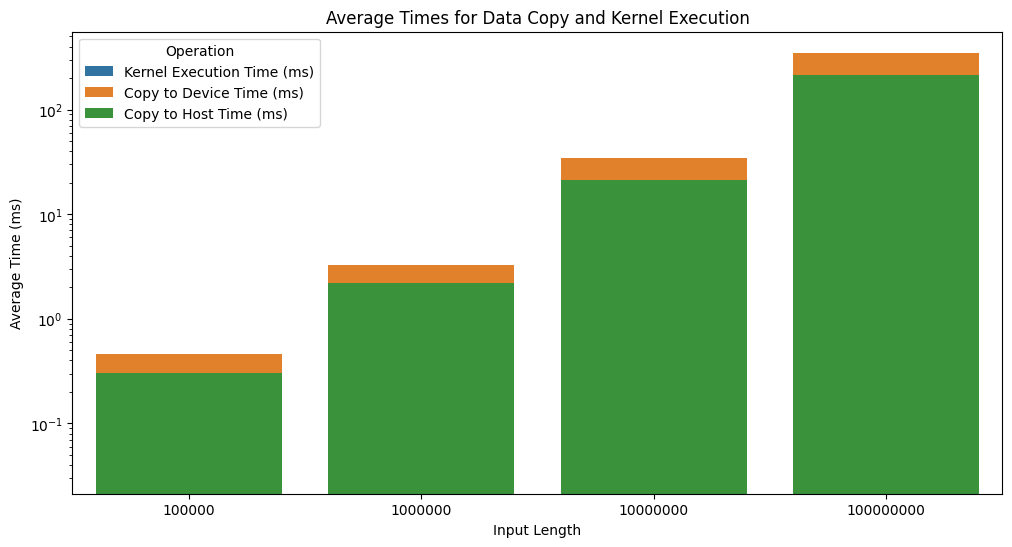

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pandas as pd

def parse_results(results_str):
    """
    Parses the results of multiple test runs and returns a DataFrame.

    Args:
    - results_str (str): A string containing the test run output.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the parsed results.
    """

    # Regex pattern to match each block of results for a single input length
    pattern = r"The input length is (\d+), \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Input length \d+, \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to device: +([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to host: +([\d.]+) \+- [\d.]+ ms"

    # Use regex to find all matches in the string
    matches = re.findall(pattern, results_str)

    # Create a list to store the parsed data
    data = []

    # Parse each match and store as a dictionary
    for match in matches:
        input_length = int(match[0])
        kernel_time = float(match[1])
        copy_to_device_time = float(match[2])
        copy_to_host_time = float(match[3])

        # Append the parsed data to the list
        data.append({
            "Input Length": input_length,
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage with the input printout string
results_str = """
The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0338 +- 0.0579 ms
Average time for data copy to device:     0.4606 +- 0.0284 ms
Average time for data copy to host:       0.3056 +- 0.1264 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1145 +- 0.0502 ms
Average time for data copy to device:     3.2693 +- 0.1583 ms
Average time for data copy to host:       2.1796 +- 1.2151 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9398 +- 0.0547 ms
Average time for data copy to device:     34.1295 +- 0.7819 ms
Average time for data copy to host:       21.0678 +- 11.7128 ms
The input length is 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Input length 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Average kernel execution time of 10 runs: 9.1669 +- 0.0574 ms
Average time for data copy to device:     349.7391 +- 15.5713 ms
Average time for data copy to host:       213.4426 +- 116.5841 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the resulting DataFrame
print(df)

# # Data preparation
# data = {
#     "Input Length": [100000, 1000000, 5000000, 10000000, 50000000, 100000000],
#     "Kernel Execution Time (ms)": [0.0332, 0.1134, 0.4788, 0.9397, 4.5879, 9.1720],
#     "Copy to Device Time (ms)": [0.4653, 3.2890, 16.9438, 34.2606, 171.6111, 335.4579],
#     "Copy to Host Time (ms)": [0.3076, 2.1924, 10.8117, 21.0833, 104.4536, 207.1870]
# }

# # Convert the data into a pandas DataFrame
# df = pd.DataFrame(data)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(id_vars="Input Length",
                    value_vars=["Kernel Execution Time (ms)", "Copy to Device Time (ms)", "Copy to Host Time (ms)"],
                    var_name="Operation",
                    value_name="Time (ms)")

# Plotting the stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Input Length", y="Time (ms)", hue="Operation", dodge=False)

# Adding plot details
plt.title("Average Times for Data Copy and Kernel Execution")
plt.xlabel("Input Length")
plt.ylabel("Average Time (ms)")
plt.yscale("log")  # Log scale can help better visualize the differences across large ranges
plt.legend(title="Operation", loc="upper left")

plt.show()
